In [71]:
# identify samples with existing code
nsamples = 5
description='8172016 10 samples, mean -1, -2, mean +1 + 2 std, 90% unmasked'

name = 'plumbing_test_0817_v1'
import csv
import matplotlib
import time
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import ndio.remote.neurodata as neurodata

token_synapse = 'MP4merged'
channel_synapse = 'annotation'
nd = neurodata()
%matplotlib inline

filename = 'merged_mask_v5_layer23only_DSP.csv' # layer 23 mask
fields = [
    'xstart', 'ystart', 'zstart',
    'xstop', 'ystop', 'zstop', 'res',
    'total_pix', 'mask_core_pix', 'mask_fraction',
    'syn_count_unmasked', 'density', 'syn_count_total',
    'center_x', 'center_y', 'center_z', 'center_res'
]

raw = open(filename, 'r').readlines()
reader = csv.reader(raw)

data = [[float(col) for col in row] for row in reader]
data = np.asarray(data)


# data preprocessing and basic statistics
# we eliminate regions that have more than 75% masking to reduce spurrious counts

idx = np.where(data[:,9] < 0.1)

print np.shape(data)
d_new = data[np.ravel(idx),:]

# how many blocks?
print np.shape(d_new)


# we compute basic statistics

d_mean = np.mean(d_new[:,11])
d_std = np.std(d_new[:,11])

print d_mean
print d_std

print d_mean - 1*d_std
print d_mean + 1*d_std

# indices with high and low density
idx_low = np.where((d_new[:,11] < d_mean - 1*d_std) & (d_new[:,11] > d_mean - 2*d_std))[0]
idx_high = np.where((d_new[:,11] > d_mean + 1*d_std) & (d_new[:,11] < d_mean + 2*d_std))[0]

print len(idx_low)
print len(idx_high)

(101649, 17)
(9240, 17)
1.56272792208
0.316401966037
1.24632595604
1.87912988812
1281
1152


In [13]:
# randomly permute each set of indices
iilow = np.random.permutation(idx_low)
iihigh = np.random.permutation(idx_high)

# choose first n from each
ind = np.ravel([np.ravel(iilow[0:nsamples]),np.ravel(iihigh[0:nsamples])])
# randomly permute that list of indices
ind = np.random.permutation(ind)

tvec = np.zeros([nsamples*2,4])
c = 0
for i in ind:
    tvec[c,0] = c
    tvec[c,1] = i
    tvec[c,3] = d_new[i,11]

    if tvec[c,3] > d_mean:
        tvec[c,2] = 1
    
    c += 1


# save [bias_id, index, truth 0/1, density estimate]
# for each index
np.save(name,tvec=tvec,description=description, name=name, d_new=d_new)

0000 52.1160891056
0001 68.3815941811
0002 65.7353570461
0003 70.2069439888
0004 65.5051009655
0005 61.7910990715
0006 1541.60798192
0007 72.6677939892
0008 68.7058968544
0009 63.2872898579


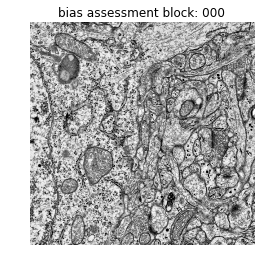

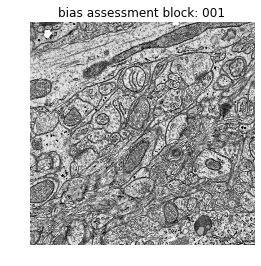

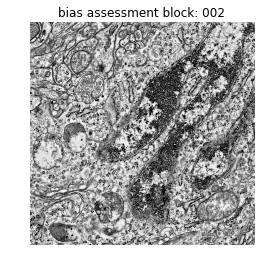

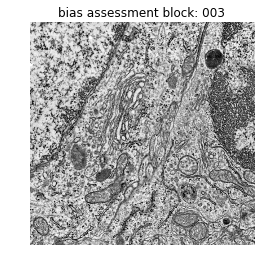

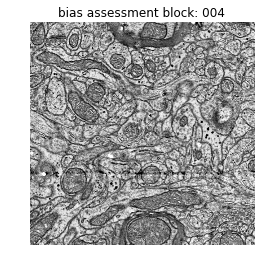

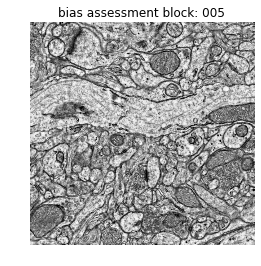

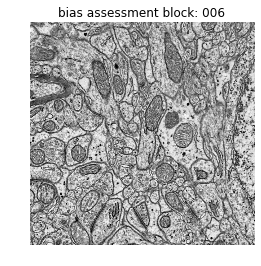

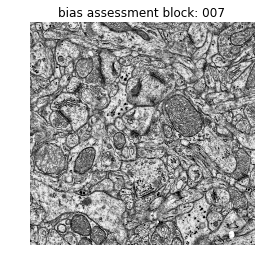

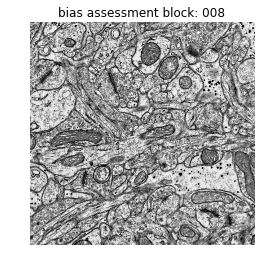

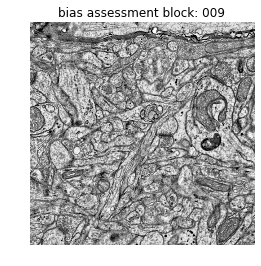

In [14]:
## Generate all data cubes

cube_idx = tvec[:,1]

token_mask = 'bock11_mask_v1'
channel_mask = 'mask'
from ndio.remote import neurodata as neurodata
nd = neurodata(chunk_threshold=2e9,suppress_warnings=True)
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import animation
from time import time

c = 0
for x in cube_idx:
    x = int(x)
    print str(c).zfill(4),
    xstart = int(d_new[x,0])*2**4
    ystart = int(d_new[x,1])*2**4
    zstart = int(d_new[x,2])
    xstop = int(d_new[x,3])*2**4
    ystop = int(d_new[x,4])*2**4
    zstop = zstart+111
    resolution = 1
    #mask = nd.get_cutout(token_mask, channel_mask, xstart, xstop, ystart, ystop, zstart, zstop, resolution=1)
    im = nd.get_cutout('bock11', 'image', xstart, xstop, ystart, ystop, zstart, zstop, resolution=1)


    start = time()
    nFrames = im.shape[2]
    titletext = 'bias assessment block: '+str(c).zfill(3)
    # Set up plotting
    fig = plt.figure()

    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=3, metadata=dict(artist='wrgr'), bitrate=8192)

    # Animation function
    def animate(i): 
        figure = plt.imshow(im[:,:,i],cmap='gray')
        figure.axes.set_axis_off()    
        plt.title(titletext)
        ax = plt.axes()  
        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.set_axis_off()
        plt.autoscale(tight=True)

        return figure  

    anim = animation.FuncAnimation(fig, animate, frames=nFrames,blit=False)
    #plt.show()

    anim.save(name+'_' + str(c).zfill(3)+'.mp4', writer=writer)
    print time()-start
    c += 1
# Truth by whatever means desired

# Save off a vector

# Load in a vector

# compare with truth and assess performance




In [69]:
import numpy as np

d = []
import csv
with open('plumbing_test_0817_v1_will.csv', 'rU') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        #print ', '.join(row)
        d.append(row)
d = np.asarray(d,'int')
d = d[:,1]

data = np.load('plumbing_test_0817_v1.npz')
tvec = data['tvec']
t = np.asarray(tvec[:,2],'int')

In [68]:
print('************************************************************************************************')
print('Test Run: ' + str(data['name']))
print('Test Description: ' + str(data['description']))
print('Accuracy: '+ str(1.0*np.sum(t==d)/len(d)*100) + '%')
print('Total Samples: ' + str(len(d)))
print('True Positives: ' + str(np.sum((t==d) & (d==1))))
print('True Negatives: ' + str(np.sum((t==d) & (d==0))))
print('False Positives: ' + str(np.sum((t!=d) & (t==0))))
print('False Negatives: ' + str(np.sum((t!=d) & (t==1))))
print('************************************************************************************************')

************************************************************************************************
Test Run: plumbing_test_0817_v1
Test Description: 8172016 10 samples, mean -1, -2, mean +1 + 2 std, 90% unmasked
Accuracy: 100.0%
Total Samples: 10
True Positives: 5
True Negatives: 5
False Positives: 0
False Negatives: 0
************************************************************************************************
